It is common to believe that deep learning is the only way to manage Image recognition.
In fact AutoML also provides (an easier) solution. 
We will show that AutoML by PredicSis.ai provides an efficient and simple solution.

Let's begin using the notMNIST datasets provided by Google in it deep learning tutorial available on Udacity ([this mock course](https://classroom.udacity.com/courses/ud730)). 
Those datasets provide sets of letter pictures:
 - a large one used to train ([here](https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz))
 - a small one used to test ([here](https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz))
 
So the goal is to fit a model to recognize if those kind of pictures:

<div style="background-color: gray; padding:2px; margin:40px; transform: scale(2.5)">
<table>
    <tr>
    <td>![Image of a A](raw.png) </td>
    <td>![Image of a B](b.png)</td>
    <td>![Image of a C](c.png)</td>
    <td>...</td>
    </tr>
</table>
</div>
are A, B, C, D, E, F, G, H, I or J.

We start by the simplest image processing to a csv dataset. (With autoML there is no need to normalize or transform pixels information... PredicSis.ai workflow includes an optimized and optimal statistic reduction discuss in the following.)

Requirements:
 - python  
   - scipy, numpy, pandas, matplotlib
   - predicsis python SDK (http://predicsis-python-sdk.readthedocs.io) 
 - PredicSis.ai instance ([AWS Marketplace](https://aws.amazon.com/marketplace/search/results?x=0&y=0&searchTerms=predicsis))

# Few line of python code

In [1]:
from scipy import ndimage
import os

In [9]:
im_size = 28

headers = ['index'] + ['p%dx%d' % (x, y) 
          for x in range(im_size) 
          for y in range(im_size)] + ['letter']

for t in ['train', 'test']:
    i = 0
    with open('pdataset_%s.csv' % t, 'w') as dataset:
        dataset.write(','.join(headers) + '\n')
        for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
            for image_file in os.listdir(os.path.join(os.path.curdir, t, letter)):
                try:
                    im = ndimage.imread(os.path.join(os.path.curdir, t, letter, image_file)).astype(float)
                except IOError:
                    print os.path.join(os.path.curdir, t, letter, image_file) + ' cannot be identify!'
                    continue
                if im.shape != (im_size, im_size):
                    print os.path.join(os.path.curdir, t, letter, image_file) + ' is corrupted!'
                    continue
                image_row = [i] + [im[x][y] 
                             for x in range(im_size) 
                             for y in range(im_size)]
                i += 1
                dataset.write(','.join(map(lambda npfloat: repr(float(npfloat)), image_row)) + ',' + letter + '\n')

./train/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png cannot be identify!
./train/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png cannot be identify!
./train/A/Um9tYW5hIEJvbGQucGZi.png cannot be identify!
./train/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png cannot be identify!
./train/D/VHJhbnNpdCBCb2xkLnR0Zg==.png cannot be identify!
./test/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png cannot be identify!
./test/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png cannot be identify!


Once we build datasets, let PredicSis.ai works:

 - load the python SDK libraries:

In [2]:
from predicsis import PredicSis

 - create a new project `notMNIST`
 - automatically fit a model

In [9]:
pj = PredicSis.create_project(
    'notMNIST', {
        'name': 'notMNIST',
        'train': './pdataset_train.csv',
        'test': './pdataset_test.csv'
    },
    key='index',
    target='letter',
    main_modality='A',
    separator=','
)
mod = pj.default_schema().fit('model')

We obtain the following results:

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

- auc
- accuracy
- cumulative gain charts:

Area Under Curve: 0.959334
Accuracy: 0.771051


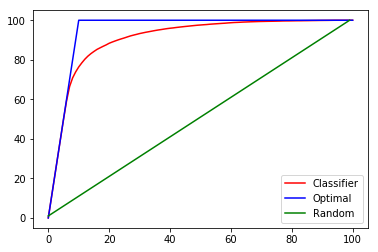

In [54]:
a, = plt.plot(mod.cumulative_gain()['classifier'], 'r-', label='Classifier')
b, = plt.plot(mod.cumulative_gain()['optimal'], 'b-', label='Optimal')
c, = plt.plot(range(1,101), 'g-', label="Random")
plt.legend(handles=[a, b, c])
print "Area Under Curve:", mod.auc()
print "Accuracy:", mod.accuracy()
plt.show()

- confusion matrix and global and recall

In [57]:
import pandas

cm = mod.confusion_matrix()
df = pandas.DataFrame(cm['matrix'], columns=cm['modalities'], index=cm['modalities'])
df['positive'] = df[['A','B','C','D','E','F','G','H','I','J']].max(axis=1)
df['sum'] = df[['A','B','C','D','E','F','G','H','I','J']].sum(axis=1)
df['recall'] = df['positive'].div(df['sum'])
del df['positive']
del df['sum']
df

,A,B,C,D,E,F,G,H,I,J,recall
A,39804,1558,788,1254,1183,857,1184,2517,1367,998,0.772743
B,1489,40042,1130,2832,1872,708,2159,1167,1362,594,0.750483
C,308,223,41500,389,2692,265,3666,238,596,329,0.826594
D,927,2319,362,41535,280,297,591,681,531,810,0.859351
E,576,1697,2029,686,37966,775,1700,1861,1345,389,0.774437
F,645,987,962,1108,2874,46173,1425,1975,2092,1288,0.775639
G,1701,2355,4210,1682,2638,1103,39185,1315,1318,1647,0.685604
H,4267,1043,357,1018,700,477,930,40882,1009,530,0.798274
I,921,1011,819,939,1612,1014,872,968,38114,3553,0.764988
J,2271,1676,755,1468,1095,1243,1200,1308,5178,42773,0.725372


# What's happened?

PredicSis.ai uses a really smart pipeline of automatic machine learning to fit a model. It applies:
 - (an smart aggregates generators on relational data)
 - an optimal statistical reduction ([scientific paper: MODL](http://www.marc-boulle.fr/publications/BoulleML06.pdf)) which select relevant features and optimize them
 - and a bootstrap aggregating algorithm over Naive Bayes classifier ([scientific paper: SNB](http://www.marc-boulle.fr/publications/BoulleJMLR07.pdf))

The statistical reduction step transforms raw images to optimized images (means statistically interesting):

<div style="background-color: gray; padding:-2px; margin:55px; transform: scale(2.5)">
<table>
    <tr>
    <th>Raw</td>
    <th></td>
    <th>Optimized</td>
    </tr>
    <tr>
    <td>![raw](a.png)</td>
    <td>--></td>
    <td>![disc](disc.jpg)</td>
    </tr>
</table>
</div><br/>

The classifier computes for each image if it seems to be a A, B, ...:

<div style="background-color: gray; padding:-2px; margin:55px; transform: scale(2.5)">
<table>
    <tr>
    <th>Raw</td>
    <th></td>
    <th>Predicted</td>
    </tr>
    <tr>
    <td>![raw](e.png)</td>
    <td>--></td>
    <td>E (97.5%)</td>
    </tr>
</table>
</div><br/>

So in few lines we have obtained an good image classifier ready to real time prediction.

# Next steps

The AUC is really good but the recall need to be improve. Right! In a next post we will show how to use smart aggregates over images to improve the recognition ;-).
In an other blog post, we show how to use this optimal statistical reduction (MODL) to reduce noise and accelerate training of a recurrent neural network (with tensorflow).